In [4]:
!module load gcc/6.3.0 python_gpu/3.7.4 hdf5/1.10.1


Due to MODULEPATH changes, the following have been reloaded:
  1) jpeg/9b           3) openblas/0.2.19      5) r/3.5.1
  2) libpng/1.6.27     4) python_cpu/3.6.4

The following have been reloaded with a version change:
  1) gcc/4.8.5 => gcc/6.3.0



In [5]:
!pip install -U --user sentence-transformers

  Using cached https://files.pythonhosted.org/packages/50/10/aeefced99c8a59d828a92cc11d213e2743212d3641c87c82d61b035a7d5c/transformers-2.3.0-py3-none-any.whl
  Found existing installation: transformers 2.7.0
    Uninstalling transformers-2.7.0:
      Successfully uninstalled transformers-2.7.0
You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install --user transformers

  Using cached https://files.pythonhosted.org/packages/37/ba/dda44bbf35b071441635708a3dd568a5ca6bf29f77389f7c7c6818ae9498/transformers-2.7.0-py3-none-any.whl
    100% |████████████████████████████████| 3.7MB 3.5MB/s eta 0:00:01    17% |█████▌                          | 645kB 11.0MB/s eta 0:00:01    34% |███████████                     | 1.3MB 13.3MB/s eta 0:00:01    84% |███████████████████████████▏    | 3.2MB 24.0MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/93/83/71a2ee6158bb9f39a90c0dea1637f81d5eef866e188e1971a1b1ab01a35a/filelock-3.0.12-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2a/5c/defec5286e293b5dedb757d1a51f3d342e8f098f2dae4134495471330687/boto3-1.12.36-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/a6/b4/7a41d630547a4afd58143597d5a49e07bfd4c42914d8335b2a5657efc14b/sacremoses-0.0.38.tar.gz
    100% |████████████████████████████████| 61kB 5.4MB/s eta 0:00:01
    100% |███████████████████████████

In [1]:
import torch
from torch.utils import data
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from itertools import islice
import os
import json
from time import time
from collections import Counter
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tnrange, tqdm

text_path = 'data/preprocessed_text.json'

I0406 14:08:41.146720 47003742518720 file_utils.py:35] PyTorch version 1.4.0 available.


In [2]:
with open('data/preprocessed_text.json', 'r') as f:
    articles = json.load(f)
len(articles.keys())

33375

In [3]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

In [4]:
# original scibert
tokenizer_scibert = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
model_scibert = AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
# bert finetuned on covid
tokenizer_covid = AutoTokenizer.from_pretrained('deepset/covid_bert_base')
model_covid = AutoModel.from_pretrained('deepset/covid_bert_base')
# bert for sentences
model_sent = SentenceTransformer('bert-base-nli-mean-tokens')

I0406 14:08:48.613653 47003742518720 tokenization_utils.py:327] Model name 'allenai/scibert_scivocab_uncased' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, bert-base-finnish-cased-v1, bert-base-finnish-uncased-v1). Assuming 'allenai/scibert_scivocab_uncased' is a path or url to a directory containing tokenizer files.
I0406 14:08:48.615148 47003742518720 tokenization_utils.py:359] Didn't find file allenai/scibert_scivocab_uncased/added_tokens.json. We won't load it.
I0406 14:08:48.616014 47003742518720 tokenization_utils.py:359] Didn't find file

I0406 14:08:55.035675 47003742518720 modeling_utils.py:403] loading weights file /cluster/home/cagomes/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/0_BERT/pytorch_model.bin
I0406 14:08:56.564816 47003742518720 tokenization_utils.py:327] Model name '/cluster/home/cagomes/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/0_BERT' not found in model shortcut name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-unc

In [5]:
def cosine_similarity(first, second):
    with torch.no_grad():
        numerator = torch.dot(first, second)
        denominator = torch.norm(first) * torch.norm(second)
        return (numerator / denominator).item()

In [10]:
def sentence_embedding(sentence, average=False):
    encoded = tokenizer_scibert.encode(sentence, add_special_tokens=True)
    with torch.no_grad():
         output = model_scibert(torch.tensor([encoded]))
    if average:
        return output[0].squeeze().mean(axis=0)
    return output[0][:, 0, :].squeeze()

In [11]:
def sentence_similarity(first, second):
    return cosine_similarity(sentence_embedding(first), sentence_embedding(second))

In [12]:
sentence_similarity("What are the risk factors for the virus?", "Fever was one of the symptoms of the virus.")

0.7844191789627075

## Generate title embeddings OR just load them
Generation will take about 30 minutes per model for the full titles

### Crop paper titles to the first sentence. Drop those that are still too large

In [13]:
def drop_from_lists(lists, indices):
    for index in sorted(indices_to_drop, reverse=True):
        for l in lists:
            l.pop(index)

In [14]:
def get_encodings_drop_long(text, tokenizer, max_length=30):
    encoded = [tokenizer.encode(title, add_special_tokens=True) for title in text]
    padded = []
    # get rid of titles longer than 30 tokens
    dropped = 0
    indices_to_drop = []
    for index, s in enumerate(encoded):
        if len(s) > max_length:
            indices_to_drop.append(index)
            dropped += 1
            continue
        padded.append(s)
        for i in range(len(s), max_length):
            padded[-1].append(0)
    print("Dropped {} titles".format(dropped))
    return torch.tensor(padded), indices_to_drop

In [16]:
# select n papers
n = 500
max_length = 30
selection = take(500, articles)
selected_papers = {key: articles[key] for key in selection}
titles = [paper_json[1]['title'] for paper_json in selected_papers.items()]
cropped_titles = []
for title in titles:
    dot_index = title.find(".")
    if dot_index == -1:
        cropped_titles.append(title)
    else:
        cropped_titles.append(title[0:dot_index + 1])

# first run removes titles that are too long, 
# second run builds actual embeddings once both tokenizers have removed those that are too long

encoded_scibert, indices_to_drop = get_encodings_drop_long(cropped_titles, tokenizer_scibert, max_length = max_length)
drop_from_lists([cropped_titles, titles], indices_to_drop)

encoded_covid, indices_to_drop = get_encodings_drop_long(cropped_titles, tokenizer_covid, max_length = max_length)
drop_from_lists([cropped_titles, titles], indices_to_drop)

encoded_scibert, indices_to_drop = get_encodings_drop_long(cropped_titles, tokenizer_scibert, max_length = max_length)
drop_from_lists([cropped_titles, titles], indices_to_drop)

encoded_covid, indices_to_drop = get_encodings_drop_long(cropped_titles, tokenizer_covid, max_length = max_length)
drop_from_lists([cropped_titles, titles], indices_to_drop)

Dropped 65 titles
Dropped 32 titles
Dropped 0 titles
Dropped 0 titles


#### Generate

In [17]:
batch_size = 32
title_generator = data.DataLoader(encoded_scibert, batch_size=batch_size, num_workers=4)
embeddings_scibert = torch.zeros(encoded_scibert.shape[0], 768)
embeddings_covid = torch.zeros(encoded_scibert.shape[0], 768)
with torch.no_grad():
    cur_index = 0
    t = tqdm(iter(title_generator), leave=False, total=len(title_generator))
    for i, batch in enumerate(t):
        cur_index += batch_size
        output_scibert = model_scibert(batch)
        embeddings_scibert[cur_index - batch_size: cur_index] = output_scibert[0][:, 0, :]

title_generator = data.DataLoader(encoded_covid, batch_size=batch_size, num_workers=4)
with torch.no_grad():
    cur_index = 0
    t = tqdm(iter(title_generator), leave=False, total=len(title_generator))
    for i, batch in enumerate(t):
        cur_index += batch_size
        output_covid = model_covid(batch)
        embeddings_covid[cur_index - batch_size: cur_index] = output_covid[0][:, 0, :]

embeddings_sent = torch.tensor(model_sent.encode(cropped_titles))

Batches: 100%|██████████| 51/51 [00:14<00:00,  3.61it/s]


In [17]:
torch.save(embeddings, "embeddings.pt")

#### Load

In [12]:
embeddings = torch.load("embeddings.pt")

In [46]:
def get_query_embedding(tokenizer, model, query):
    query_enc = tokenizer.encode(query, add_special_tokens=True)
    for i in range(len(query_enc), max_length):
        query_enc.append(0)
    query_enc = torch.tensor([query_enc])
    with torch.no_grad():
        query_output = model(query_enc)
    return query_output[0][:, 0, :]

In [52]:
query = "Spread of covid-19 models"
query_embedding_scibert = get_query_embedding(tokenizer_scibert, model_scibert, query)
query_embedding_covid = get_query_embedding(tokenizer_covid, model_covid, query)
query_embedding_sent = torch.tensor(model_sent.encode([query]))

Batches: 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


In [48]:
def find_top_n_similar(embeddings, query_embedding, n=20):
    similarity = F.cosine_similarity(embeddings, query_embedding)
    index_sorted = torch.argsort(similarity, descending=True)
    return [titles[i] for i in index_sorted.tolist()[:n]]

In [53]:
n = 20
print(find_top_n_similar(embeddings_scibert, query_embedding_scibert, n=n))

['Adaptive Estimation for Epidemic Renewal and Phylogenetic Skyline Models', 'Transmission potential of COVID-19 in Iran 1', 'BAR scaffolds drive membrane fission by crowding disordered domains', 'Recombinant vector vaccines and within-host evolution 1', 'Estimation of risk factors for COVID-19 mortality -preliminary results', 'Title: Probabilistic reconstruction of measles transmission Authors', 'Epidemic analysis of COVID-19 in China by dynamical modeling', 'Similar ratios of introns to intergenic sequence across animal 1 genomes', '(dry-33 iminli@vip', 'Kin and group selection are both flawed but useful data analysis tools', 'Machine intelligence design of 2019-nCoV drugs', 'A Generalized Discrete Dynamic Model for Human Epidemics', 'TALC: Transcription Aware Long Read Correction', 'Retrospective Analysis of Clinical Features in 101 Death Cases with COVID-19', 'Remote control of neural function by X-ray-induced scintillation', 'Estimating Spot Prevalence of COVID-19 from Daily Death

In [54]:
print(find_top_n_similar(embeddings_covid, query_embedding_covid, n=n))

['Speed and strength of an epidemic intervention', 'Machine intelligence design of 2019-nCoV drugs', 'Cross-sectional Study Affiliations', 'SKEMPI 2.0: An updated benchmark of changes in protein-protein binding energy, kinetics and thermodynamics upon mutation', 'Robitaille et al. 1 DUSP1 regulates apoptosis and cell migration, but not the JIP1-protected cytokine response, during Respiratory Syncytial Virus and Sendai Virus infection', 'Transmission potential of COVID-19 in Iran 1', 'Correcting under-reported COVID-19 case numbers', 'Mycroft-West et al. (2020) Running title: SARS-CoV-2 surface S1 Receptor Binding Domain binds heparin The 2019 coronavirus (SARS-CoV-2) surface protein (Spike) S1 Receptor Binding Domain undergoes conformational change upon heparin binding', 'Evolution and variation of 2019-novel coronavirus', '', '', '', '', '', '', '', '', '', '', '']


In [55]:
print(find_top_n_similar(embeddings_sent, query_embedding_sent, n=n))

['Transmission interval estimates suggest pre-symptomatic spread of COVID-19', 'Identification of a super-spreading chain of transmission associated with COVID-19', 'Title: COVID-19 Progression Timeline and Effectiveness of Response-to-Spread Interventions across the United States', 'Relations of parameters for describing the epidemic of COVID-19 by the Kermack-McKendrick model', 'Dynamic profile of severe or critical COVID-19 cases', 'Fractal kinetics of COVID-19 pandemic (with update 3/1/20)', 'Association between 2019-nCoV transmission and N95 respirator use', 'Correcting under-reported COVID-19 case numbers', 'Characterizing the transmission and identifying the control strategy for COVID-19 through epidemiological modeling', 'High transmissibility of COVID-19 near symptom onset', 'Estimation of risk factors for COVID-19 mortality -preliminary results', 'Estimates of the severity of COVID-19 disease', 'Transmission potential of COVID-19 in Iran 1', 'A spatial model of CoVID-19 trans

In [82]:
embeddings_np = embeddings.numpy()
centered = embeddings_np - embeddings_np.mean(axis=0)
pca = PCA(n_components=50)
components = pca.fit_transform(centered)
tsne = TSNE()
result = tsne.fit_transform(components)

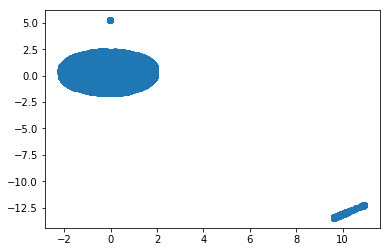

In [83]:
plt.scatter(result[:, 0], result[:, 1])